In [1]:
import numpy as np
from scipy import ndimage, misc

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

import json

# Image analysis notebook for thresholding

After recording data, it has to be analyzed. This is often difficult, time consuming and tedious. But can also be very enlightening and satisfying.

Here we have collected a few possible things one can do. Please feel free to play with all of these functions a much as you like. 

## Loading images

First we have to load the data into the notebook. Our images have the format ndata1, a numpy format that has one file with the image data and one with the metadata, so the information about imaging conditions and so on.

Depending on your data format you will have to figure out how to load it in. 

In [2]:
## example image ##
      ### you can autocomplete things like the filepaths by using the tab key ###
image = np.load('data/1264_PtSe2_HAADF_example-image_1.ndata1')['data']
metadata = np.load('data/1264_PtSe2_HAADF_example-image_1.ndata1')['metadata.json']

Now the data is loaded, we also want to plot it, that can be done with matplotlib:

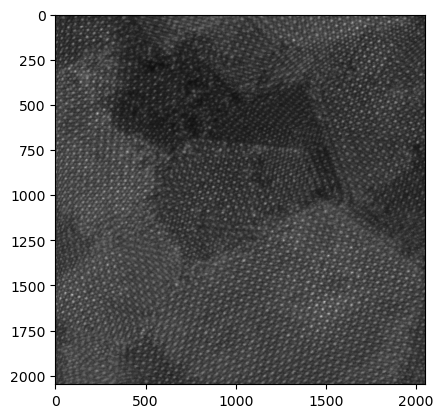

In [3]:
fig, axs = plt.subplots()
axs.imshow(image, cmap='Greys_r');

## with this you can remove the axis to make it more pretty
#plt.axis('off'); 

## Metadata ##

We know that the image has 2048 x 2048 pixels in this case, but we also want to see the real dimensions in the plot. For this we need the scale which is saved in the metadata.

The metadata is a complete mess, but it still has holds the relevant information. 


<div class="alert alert-block alert-success">
Can you spot values that could be important or that you have seen in the microscope?
</div>

In [4]:
json.loads(metadata)

{'version': 1,
 'reader_version': 1,
 'large_format': False,
 'spatial_calibrations': [{'offset': -16.0, 'scale': 0.015625, 'units': 'nm'},
  {'offset': -16.0, 'scale': 0.015625, 'units': 'nm'}],
 'intensity_calibration': {'offset': 0.0, 'scale': 1.0, 'units': ''},
 'collection_dimension_count': 0,
 'datum_dimension_count': 2,
 'metadata': {'instrument': {'high_tension': 60000.0,
   'defocus': 1.9931128064337496e-09,
   'ImageScanned': {'C1 ConstW': 0.47398,
    'EHT': 60000.0,
    'PMTBF_gain': 12800.0,
    'PMTDF_gain': 5000.0,
    'S_EELS': 6.0,
    'StageOutA': -2.3412027713847336e-08,
    'StageOutB': -2.0760257227891155e-08,
    'StageOutX': 0.00015047778825710362,
    'StageOutY': 0.0005251907939573951,
    'StageOutZ': 0.00017093066784727837,
    'FEM_AstigA': -9.044999999999998e-05,
    'FEM_AstigB': 1.3900000000000094e-05,
    'FEM_CAperture.a': 0.08860999999999858,
    'FEM_CAperture.b': -0.17719999999999958,
    'FEM_CenterA': -0.32539000000000146,
    'FEM_CenterB': 0.1277

We focus on the __scale__ for now:

In [5]:
## we access it and store it in the keyword scale ##
scale = json.loads(metadata)['spatial_calibrations'][0]['scale']
print(scale)

0.015625


### What is the scale? ###

It corresponds to how many nanometers are in one pixel. So you can calculate the size of the image from that. 

<div class="alert alert-block alert-success">
Can you figure out how?
</div>


In [6]:
## here you can try out calculations to figure out the size using the scale##

# this is our image shape in pixel 
print(image.shape)



size = 'XXX'

print(f"The size of the image is {size} nm.") # the f lets you include variables (like size here) from outside the text

(2048, 2048)
The size of the image is XXX nm.


## Do I have to do that every time?? ##

It can be a bit tideous to write these lines for all images, so I have written a function that you can use that makes it a bit easier:

In [7]:
def load_image(filepath):
    image = np.load(filepath)['data']  
    metadata = np.load(filepath)['metadata.json']

    scale = json.loads(metadata)['spatial_calibrations'][0]['scale']

    return image, scale



It can be used like this:

In [8]:
image, scale = load_image('data/1264_PtSe2_HAADF_example-image_1.ndata1')

### Plotting with the scale ###

So we imediately see how large an image is, we should plot it with a scale bar. Here I have written a function that makes a pretty plot for the images:

In [9]:
def pretty_plot(image, scale, sigma=False, save=False):

    if sigma: #you can apply a gaussian filter
        image = ndimage.gaussian_filter(image, sigma)

    ## makes a figure without anything in it ##
    fig, axs = plt.subplots(figsize=(8,8)) 

    ## shows the image on the axis of the figure ##
    axs.imshow(image, origin='lower', cmap='Greys_r')

    ## the following lines make a scalebar ##
    px_length = len(image)//8
    real_length = px_length*scale

    ## if the length of the scale bar is an integer we can remove the comma ##
    if real_length.is_integer()==True:
        real_length = int(real_length)
    
    axs.text(len(image)//32+px_length//5, len(image)//32+px_length//8, f'{int(real_length)} nm', c='w', fontsize=12)
    axs.hlines(len(image)//32, len(image)//32, len(image)//32+px_length, lw=6, color='w')

    ## here we just make it prettier by turning off the axis ##
    axs.axis('off')

    ## we can specify a savepath above where the image is saved ##
    if save:
        plt.savefig(save, dpi=300)


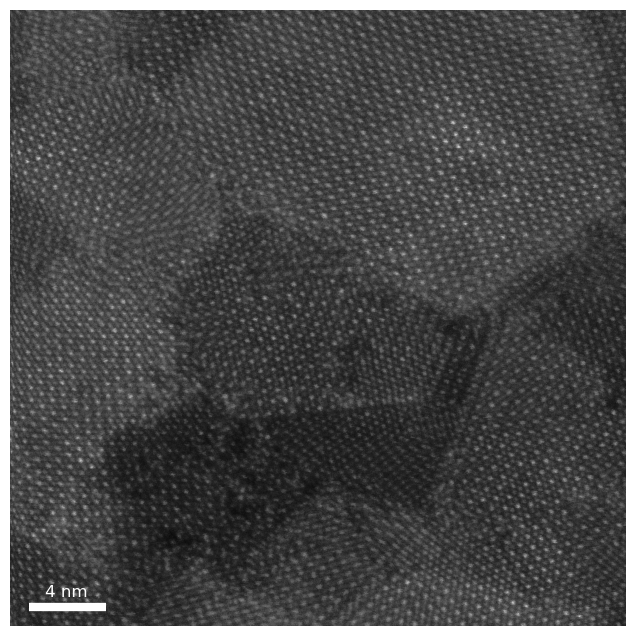

In [10]:
pretty_plot(image, scale, sigma=False)

### What does 'sigma' do? ###

As you might have noticed, the function also does an additional thing, it has a keyword 'sigma'. 

<div class="alert alert-block alert-success">
Try out different values (numbers) for this parameter and see how the plot changes. Do you have an idea of how this changes the image and why we sometimes want to use it?
</div>

In [11]:
## try out different values here ##



# Thresholding #

One possibility for data analysis, especially for polycrystalline samples like this crystal here, is thresholding. This means that we take a certain brightness of the image and only use values above or below it. 

### Example ###

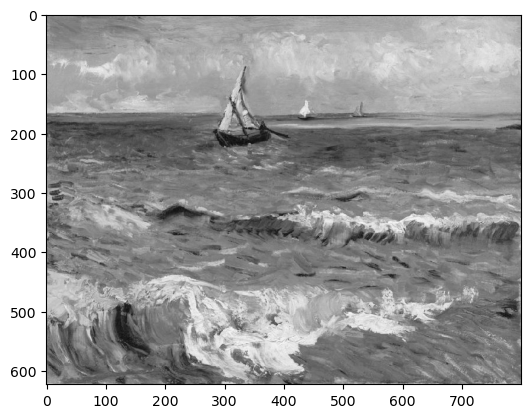

In [12]:
## look at this example image of a Van Gogh painting (Credits: Van Gogh Museum, Amsterdam (Vincent van Gogh Foundation) ##
image = np.asarray(Image.open('data/vangogh.jpg').convert('L')) #loads the image in grayscale and converts it to an array
plt.imshow(image, cmap='Greys_r')

Every pixel of the image has a specific 'gray value', so some brightness. We can count how many pixels of the image have each of the limited gray values and show this in form of a __histogram__:

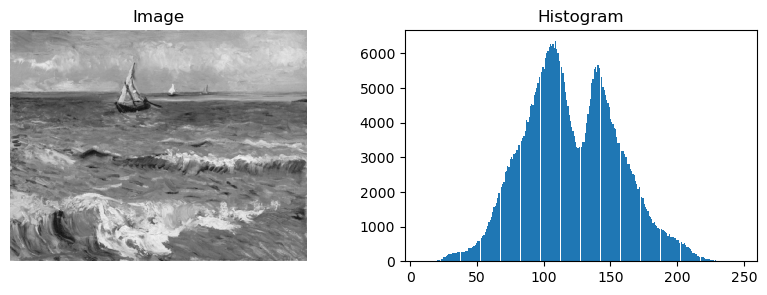

In [13]:
fig, axs = plt.subplots(1,2, figsize=(10, 3))

axs[0].imshow(image, cmap='Greys_r')
axs[0].set_title('Image')
axs[0].axis('off')

axs[1].hist(image.ravel(), bins=256)
axs[1].set_title('Histogram')

plt.show()

We see that in this case the lowest value is 0 and the highest should be 256. 

Now we can 'filter' the image by brightness, and just show brighter or less bright areas.

<div class="alert alert-block alert-success">
Can you plot an image that only shows very bright areas or very dark areas?
</div>

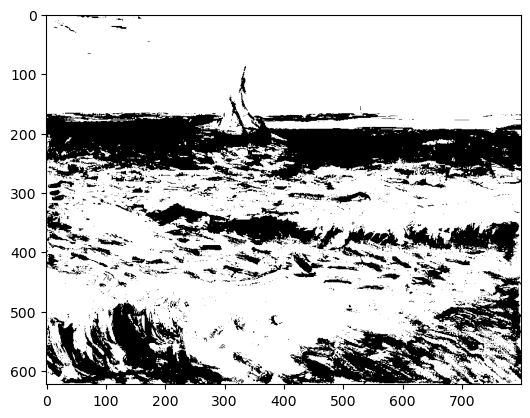

In [14]:
# feel free to just play with this threshold value ##

my_areas = np.where(image >= 100, 1, 0) # this returns an image that has the value 1 where the condition image > 0.3 is true 
                                                #and 0 otherwise
plt.imshow(my_areas, cmap='Greys_r');

We can also limit it so the intensity of the image is between some values, like this:

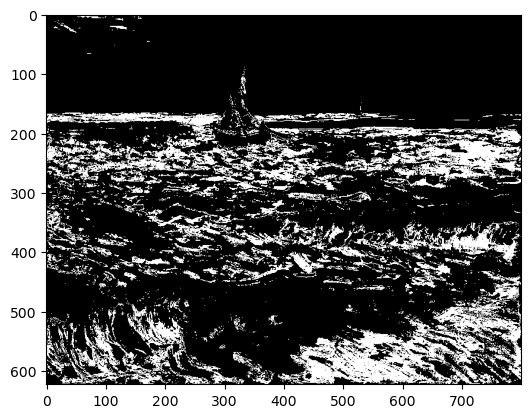

In [15]:
thresholded_image = np.where((image >= 80) & (image <= 100), 1, 0)
plt.imshow(thresholded_image, cmap='Greys_r');

## Let us apply this ##

As you have noticed in the microscope, thin areas of our samples scatter less then thicker areas, and therefore the look darker in our image. Now we can use thresholding for getting an idea of how much of our images is monolayer, bilayer, trilayer and so on by adjusting the thresholds accordingly.

I have written a thresholding function, that does the steps that you have seen above:

In [16]:
def threshold(image, sigma, lower, upper):
    if sigma:
        image = ndimage.gaussian_filter(image, sigma=sigma)
        
    binary = np.where((image >= lower) & (image <= upper), 1, 0)

    #binary = binary < upper
    
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
    ax = axes.ravel()
    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])
    
    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')
    
    ax[1].hist(image.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(lower, color='r')
    ax[1].axvline(upper, color='r')
    
    ax[2].imshow(binary, cmap='Greys_r')
    ax[2].set_title('Thresholded')
    ax[2].axis('off')
    
    plt.show()

    return binary

### So let us try this out on a real image ###

The values I show below give you the areas that are just holes in the material, so the lowest brightness in the image and 0 layers. 

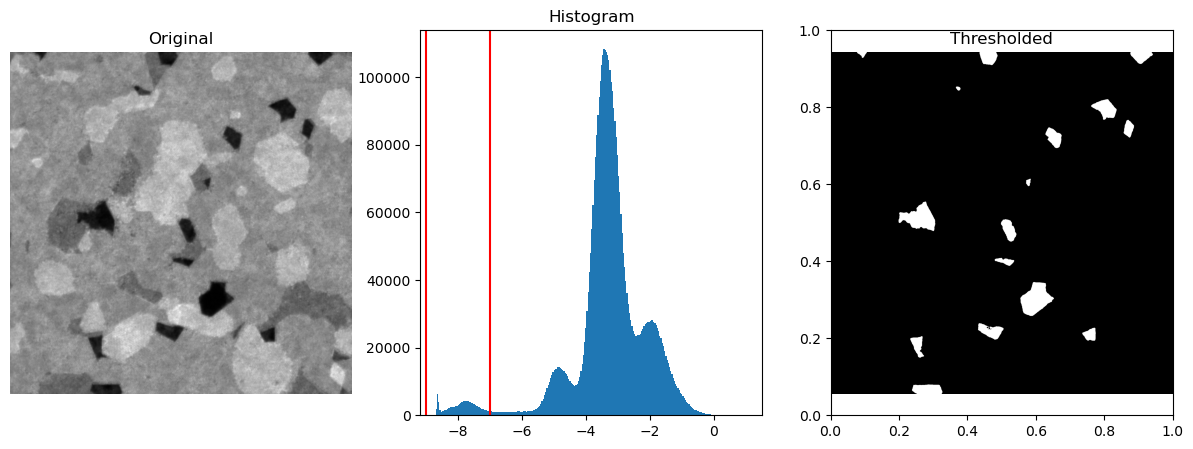

In [17]:
image, scale = load_image('data/1264_PtSe2_HAADF_example-image_2.ndata1')
binary = threshold(image*1000, sigma=3, lower=-9, upper=-7) # I multiply the image here only to make the numbers nicer

All the peaks in the histogram are intensities that are often in the image, so they are different layer thicknesses. 
<div class="alert alert-block alert-success">
Try to make binary images for all of the peaks. 
</div>

## How to get to the size from that ##

We want to know how large the areas of different thicknesses are.

In [18]:
# our whole image is 2048 x 2048 px large #

px_size = 2048*2048
print(px_size)

4194304


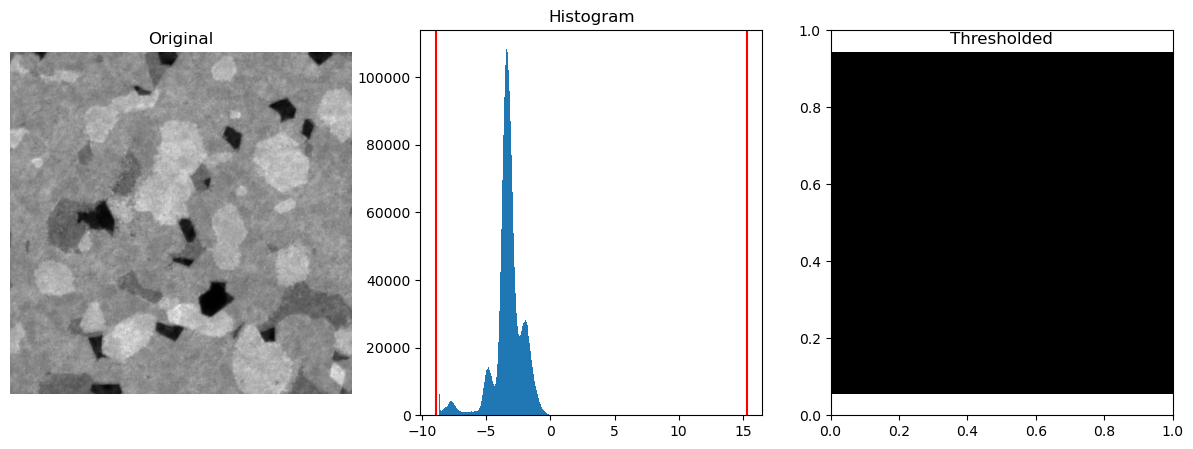

In [19]:
# if we would threshold an image so all of the pixels are included, so we have the boundaries at the upper and lower end, this would be the result: 

image, scale = load_image('data/1264_PtSe2_HAADF_example-image_2.ndata1')
binary = threshold(image*1000, 3, (image*1000).min(), (image*1000).max()) # I multiply the image here only to make the numbers nicer

In [20]:
## this looks very uninteresting, but:

print(np.sum(binary))

4194304


The sum of the thresholded image is exactly the pixel size of the image. 
<div class="alert alert-block alert-success">
Why is that the case? 
</div>


And now you also know the scale, so the nanometers per pixel. From there you can calculate the square nanometers, so area, that is in one square pixel.

<div class="alert alert-block alert-success">
How large is the whole image in square nanometer?
</div>

#### Apply this to different areas ####

So now all of the tools are here to find the size of the features you found by thresholding in nanometers squared! 
<div class="alert alert-block alert-success">
Try to figure out how much of the image (approximately) is pores (so holes in the material) and higher layer crystals (for the different peaks).
</div>


# Here you have space to also try out other things and look at different images if you like #

# For the especially interested: Why our scale is not correct #

Because it is easier we have used the scale from the metadata, so the scale that the microscope has saved for the analyis. This is good enough for an estimate somtimes, but the microscope is never completely correct with it's scalebars.

The most accurate way to find the scale is to use the crystal directly. Each material has a very constant lattice parameter, the lattice constant, that is the length between symmetric atom positions. We can use this to figure out how large our images are. 

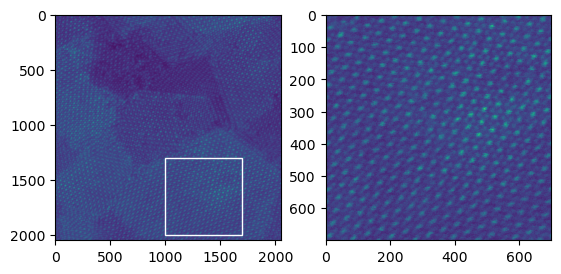

In [21]:
## Here I cut out a piece of an image that has the same orientation from this it is possible to find out the scale more correctly ##

image = np.load('data/1264_PtSe2_HAADF_example-image_1.ndata1')['data']
metadata = np.load('data/1264_PtSe2_HAADF_example-image_1.ndata1')['metadata.json']

fig, axs = plt.subplots(1,2)

axs[0].imshow(image)
xy = (1000,2000)
width = 700
selection = patches.Rectangle(xy, width, -width, linewidth=1, edgecolor='w', facecolor='none')
axs[0].add_patch(selection)

selected_image = image[xy[1]-width:xy[1], xy[0]:xy[0]+width]

axs[1].imshow(selected_image);
